Osnabrück University - Computer Vision (Winter Term 2016/17) - Prof. Dr.-Ing. G. Heidemann, Ulf Krumnack

# Exercise Sheet 02: Image Enhancement

## Introduction

This week's sheet should be solved and handed in before the end of **Sunday, November 20, 2016**. If you need help (and Google and other resources were not enough), feel free to contact your groups' designated tutor or whomever of us you run into first. Please upload your results to your group's Stud.IP folder.

## Assignment 0: Math recap (matrices and linear mappings) [0 Points]

This exercise is supposed to be very easy, does not give any points, and is voluntary. There will be a similar exercise on every sheet. It is intended to revise some basic mathematical notions that are assumed throughout this class and to allow you to check if you are comfortable with them. Usually you should have no problem to answer these questions offhand, but if you feel unsure, this is a good time to look them up again. You are always welcome to discuss questions with the tutors or in the practice session. Also, if you have a (math) topic you would like to recap, please let us know.

**a)** What is a *matrix*? How is it usually written?

Fuck off.

**b)** How is *addition of matrices* defined? What about *matrix multiplication*?

See above.

**c)** What is a *linear mapping*? What is the relation to matrices?

Every linear map can be represented by a matrix multiplication.

## Assignment 1: Contrast enhancement [6 Points]

### a) Image Contrast

Describe the concept of contrast in your own words and introduce different ways to measure it. How can low contrast be caused and when is this a problem (and when not)? What can be done to improve contrast?

**Contrast**

Image contrast is the perceived range of tonal values and brightness difference between light and dark areas of the image. Possible measures:

* Difference between largest and smallest value in the image
* Local contrast e.g. by computing for each pixel its difference to the average of its surroundings and averaging over all pixels

**Contrast enhancement**
* Use transfer function to map small range of values to a larger range. This can be linear or nonlinear

### b) Histogram equalization and entropy

How does histogram equalization work? What is entropy and how is it related to histogram equalization? For your answer focus on the (conceptually simpler) continuous case.

**Entropy** is the expected value of the information content of a _message_ (e.g. a pixel as a binary string)
Details are most easily distinguished in an image with maximum information content. Contrast is literally the information we can process (both colour and luminance) since it is what allows to distinguish regions of interest. Thus equalising the image histogram should achieve the maximum useful contrast. Since the histogram counts the proportion of pixels for each gray value, it gives the probability for each gray value and thus the information content for each pixel and the entropy can be computed. The histogram with the maximal information content is the uniform one. Thus a transfer function that transforms the original histogram closer to the uniform one is desired. The function $g^\prime(g) = \int\limits_0^g \text{Hist}(w)dw$ does exactly that. If there is many values in the histogram that are below a given intensity value $g$, $g^\prime$ in that area will have a steep incline so that these values are mapped onto a larger portion of the $y$-axis.

### c) Discrete histogram equalization

What problems occur when considering discrete images (i.e. with discrete coordinates and a finite number of gray levels)? Explain the tables on the lecture slides (CV-04 slides 22/23).

There may be gaps in the resulting histogram and due to rounding, formerly different values go into the same bin.

## Assignment 2: Computing Contrast and Entropy [6 Points]


### a) Computing contrast

Provide functions to compute the local contrast, global contrast, and entropy of an image.

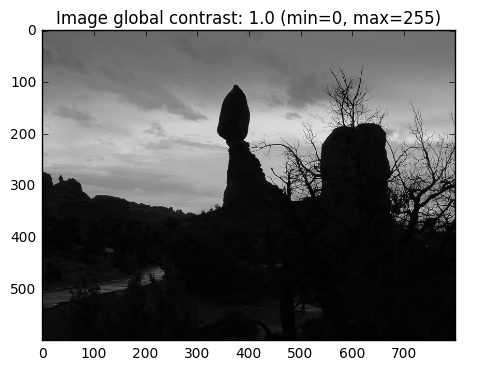

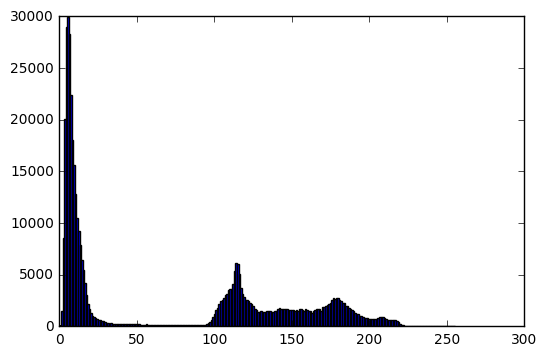

In [2]:
import numpy as np
from scipy.misc import imread
import matplotlib.pyplot as plt

def global_contrast(img, range = None):
    """
    Compute the global contrast for a given image.
    """

    # determine range: simplified, just checks for uint8 
    if range is None:
        range = (0,255) if img.dtype == np.uint8 else (0.,1.)

    c = (np.max(img) - np.min(img)) / range[1]

    return c


img = imread('dark.png')
plt.title("Image global contrast: {} (min={}, max={})".format(global_contrast(img),img.min(),img.max()))
plt.imshow(img, cmap = plt.get_cmap('gray'), vmin=0, vmax=255)
plt.show()

plt.hist(img.flatten(),256,(0,255))
plt.show()

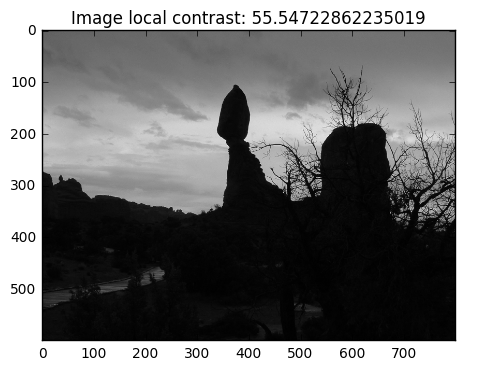

In [3]:
import numpy as np
import matplotlib.pyplot as plt

def local_contrast(img):
    """
    Compute the local contrast for a given image. Here we just ignore the pixels
    that don't have a 4-neighbourhood.
    """

    contrast = 0
    for x in range(1,img.shape[0]-1): # what to do with the edges?
        for y in range(1,img.shape[1]-1):
            contrast += np.abs(img[x,y] - .25 * np.average(np.array([img[x-1,y], img[x+1,y], img[x,y-1], img[x,y+1]])))

    return contrast / ((img.shape[0] - 2) * (img.shape[1] - 2))

        
img = imread('dark.png')

plt.title("Image local contrast: {}".format(local_contrast(img)))
plt.imshow(img, cmap = plt.get_cmap('gray'), vmin=0, vmax=255)
plt.show()

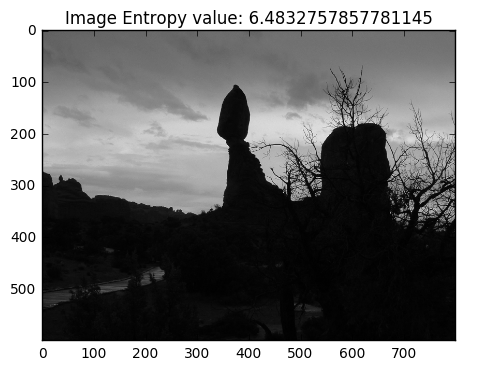

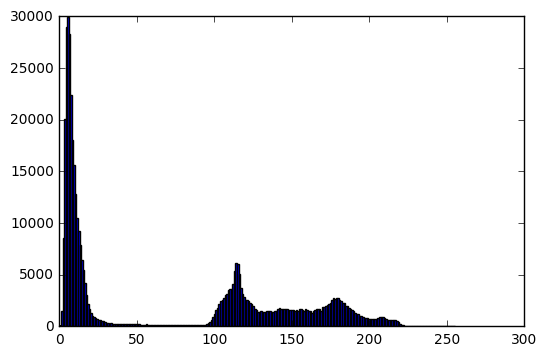

In [4]:
import numpy as np
import math
from scipy.misc import imread

def entropy(img):

    n = img.shape[0] * img.shape[1]
    h, _ = np.histogram(img, 256) 
    h = h.astype('float') / n
    e = 0
    for freq in h:
        if freq > 1e-4: # == 0 for float values
            e -= freq * np.log2(freq) 
    return e


img = imread('dark.png')
plt.title("Image Entropy value: {}".format(entropy(img)))
plt.imshow(img, cmap = plt.get_cmap('gray'), vmin=0, vmax=255)
plt.show()

plt.hist(img.flatten(),256,(0,255))
plt.show()

### b) Example images

* construct an (artificial) image with high global contrast but low local contrast
* construct an (artificial) image with low global constrast but high local contrast
* construct an (artificial) image with maximal entropy but low local contrast

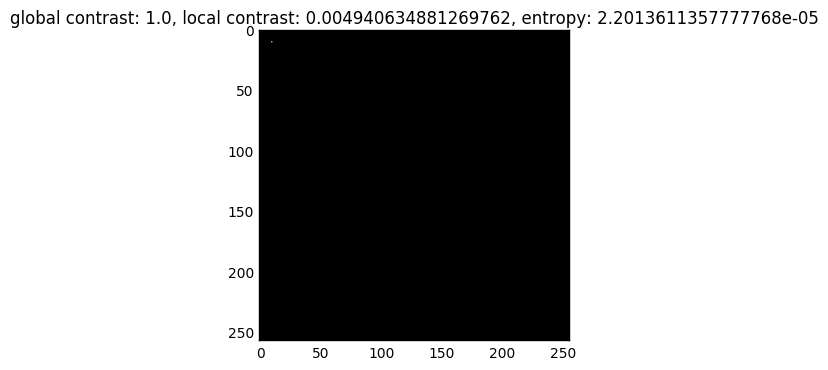

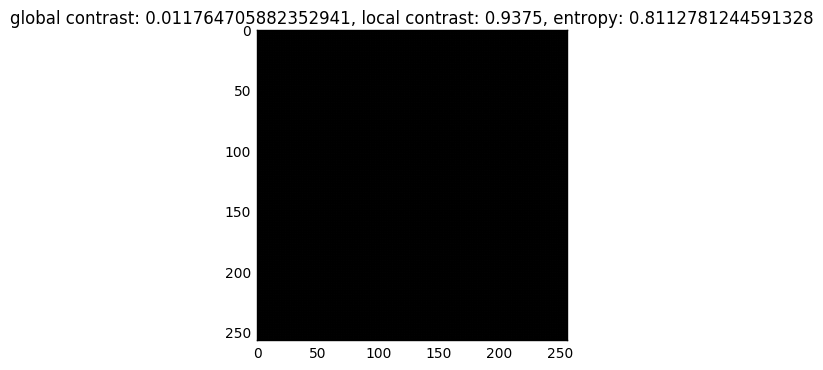

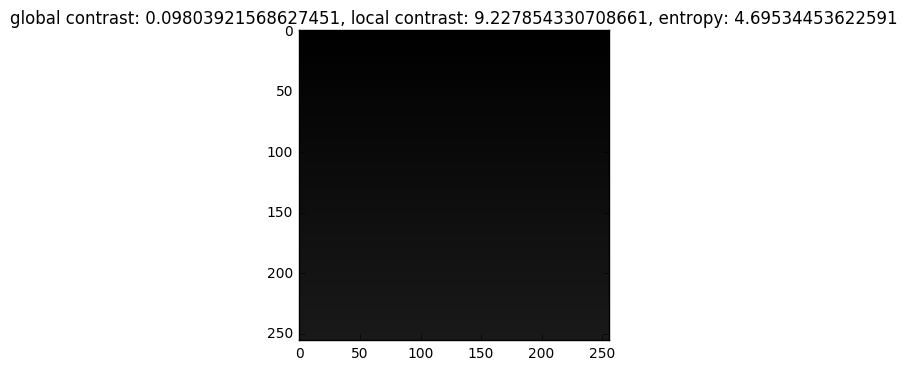

In [5]:
import numpy as np
import matplotlib.pyplot as plt

def image_info(img):
    info = "global contrast: {}, local contrast: {}, entropy: {}"
    plt.title(info.format(global_contrast(img),local_contrast(img),entropy(img)))
    plt.imshow(img, cmap = plt.get_cmap('gray'), vmin=0, vmax=255)
    plt.show()


img1 = np.zeros((256,256),np.uint8)
# high global, low local
img1 = np.zeros((256,256),np.uint8)
img1[10,10] = 255

image_info(img1)


img2 = np.zeros((256,256),np.uint8)
# high local low global
img2 = np.zeros((256,256),np.uint8)
img2[::2,1::2] = 3 # set every other element so some nonzero value in both directions


image_info(img2)


# Low local, high entropy; I have no better ideas
img3 = np.zeros((256,256),np.uint8)
for column in range(256):
    img3[column,:] = column
img3 = (img3 / 10).astype(np.uint8)

image_info(img3)

## Assignment 3: Histogram equalization [8 Points]


### a) Implement Histogram Equalization (HE)

You may use numpy function like `np.histogram`, `np.cumsum`, `np.interp`, ... here (but no buildin histogram equalization)

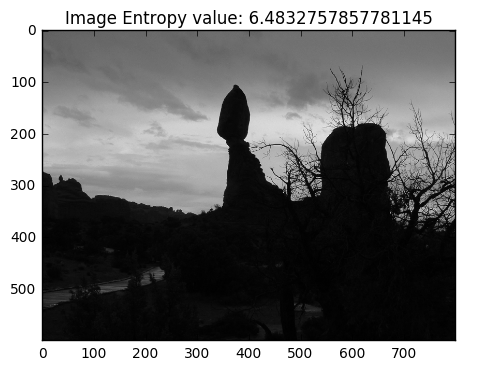

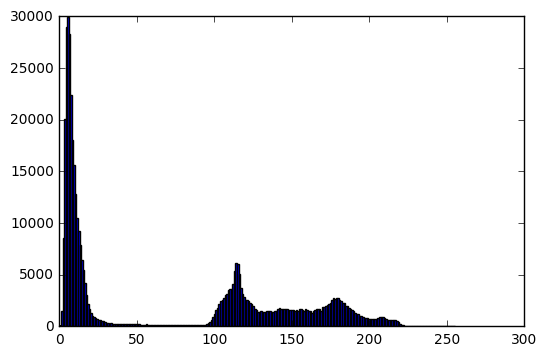

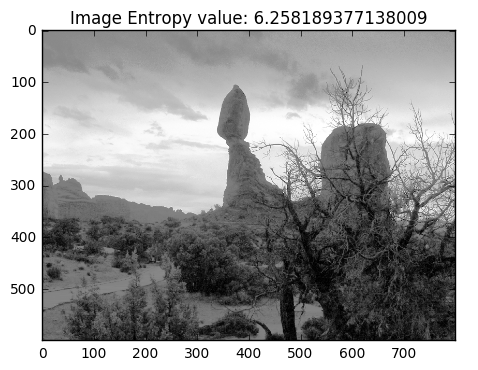

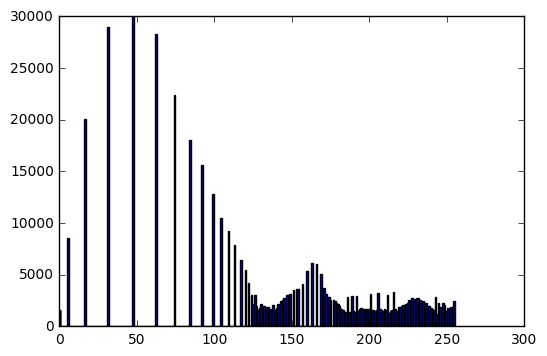

0.0 256.0


In [6]:
import numpy as np
from scipy.misc import imread
import matplotlib.pyplot as plt

def he(img):
    """
    Apply histogram equalization (HE) to the image.
    
    img: numpy.ndarray (dtype=uint8)
        The image to be equalized.
        
    Returns
    -------
    equalized: numpy.ndarray (dtype=uint8)
        The equalized image.
    """
    
    equalized = np.zeros(img.shape)
    hist, _= np.histogram(img, 256)
    h = hist / (img.shape[0] * img.shape[1])
    cumsum = h.cumsum()
    # for all gray values, change image in all pixels with that value
    for v in range(256):
        equalized[img == v] = np.ceil(256 * cumsum[v]) - 1
    return equalized



#img = imread('canada.png', mode = 'L')
img = imread('dark.png', mode = 'L')

plt.title("Image Entropy value: {}".format(entropy(img)))
plt.imshow(img, cmap = plt.get_cmap('gray'), vmin=0, vmax=255)
plt.show()

plt.hist(img.flatten(),256,(0,255))
plt.show()

img2 = he(img)
plt.title("Image Entropy value: {}".format(entropy(img2)))
plt.imshow(img2, cmap = plt.get_cmap('gray'), vmin=0, vmax=255)
plt.show()

plt.hist(img2.flatten(),256,(0,255))
plt.show()
print(img2.min(),img2.max())

### b) Implement Adaptive Histogram Equalization (AHE)

Histogram equalization has problems that it introduces gaps into the histogram. Small regions with good contrast in the original image may actually loose contrast. Adaptive histogram equalization tries to avoid this problem, by computing an individual histogram for each pixel: for every pixel choose a surrounding of a given size (e.g. 8x8 pixels) and compute "local histogram equalizations", i.e.: 

(a) compute the rank  of the pixel, i.e. how many pixels in the region have a lower intensity (gray) value

(b) compute the corresponding intensity value for the output image, i.e. $out[x,y] = \frac{\text{rank}\cdot\text{max_intensity}}{\text{number of pixels in the region}}$

See also: [Wikipedia on AHE](https://en.wikipedia.org/wiki/Adaptive_histogram_equalization)

In [7]:
import numpy as np
from scipy.misc import imread
import matplotlib.pyplot as plt

def ahe(img, size = (16,16)):
    """
    Apply adaptive histogram equalization (AHE) to the image.
    
    img: numpy.ndarray (dtype = uint8)
        The image to equalize.
    size: tuple of ints
        The size of the surrounding for which the histogram of each pixel is
        to be computed.
        
    Returns
    -------
    equalized: numpy.ndarray (dtype = uint8)
        The equalized image.
    """
    
    h         = size[0] // 2
    w         = size[1] // 2
    n         = img.shape[0]
    m         = img.shape[1]
    equalized = np.zeros(img.shape, np.uint8)
    for i in range(n):
        for j in range(m):
            region         = img[max(0, i-h):min(i+h, n), max(0, j-w):min(j+w, m)]
            max_region     = np.max(region)
            equalized[i,j] = np.sum(region < img[i,j]) * max_region / region.size

    return equalized

img = imread('canada.png', mode = 'L')


plt.title("Image Entropy value: {}".format(entropy(img)))
plt.imshow(img, cmap = plt.get_cmap('gray'), vmin=0, vmax=255)
plt.show()

plt.hist(img.flatten(),256,(0,255))
plt.show()

img2 = ahe(img)
plt.title("Image Entropy value: {}".format(entropy(img2)))
plt.imshow(img2, cmap = plt.get_cmap('gray'), vmin=0, vmax=255)
plt.show()

plt.hist(img2.flatten(),256,(0,255))
plt.show()

IndentationError: unexpected indent (<ipython-input-7-2eda809ee61d>, line 6)